In [2]:
import numpy as np
import networkx as nx
import pandas as pd

from tqdm import tqdm
from itertools import combinations
from scipy import stats
from scipy.spatial import distance
from sklearn import decomposition, preprocessing, manifold
from collections import defaultdict
from annoy import AnnoyIndex
from datetime import datetime as dt

from news_vec.utils import read_json_gz_lines
from news_vec.encoder import read_preds

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [4]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-acc-ts-ab.json/'))))

955500it [00:02, 396473.88it/s]


In [5]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

In [6]:
pairs = set(map(tuple, df[['d1', 'd2']].values.tolist()))

In [7]:
rows = []
for d1, d2 in tqdm(pairs):
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    lr = stats.linregress(pdf.window, pdf.acc)
    rows.append((d1, d2, lr.slope, lr.intercept, lr.pvalue, lr.rvalue))

100%|██████████| 105/105 [00:19<00:00,  5.51it/s]


In [8]:
lr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'intercept', 'p', 'r'))

In [9]:
tick_labels = [
    dt.fromtimestamp(ts).strftime('%-m/%Y')
    for ts in np.linspace(1483228802, 1537207799, 10, dtype='int')
]

In [10]:
tick_locs = np.linspace(0, len(df.window.unique()), len(tick_labels), dtype='int')

In [32]:
def plot_pairs(lr_df, path, w=12, h=12):

    fig, axes = plt.subplots(int(len(lr_df)/2), 2, figsize=(w,h), dpi=100)

    for i, r in enumerate(lr_df.itertuples()):

        ax = axes.reshape(-1)[i]
        pdf = df[(df.d1==r.d1)&(df.d2==r.d2)].sort_values('window')

        fitx = np.array([pdf.window.min(), pdf.window.max()])
        fity = r.slope * fitx + r.intercept

        sns.lineplot(x='window', y='acc', data=pdf, ax=ax, err_style='bars')
        ax.plot(fitx, fity, c='black', linewidth=1, alpha=0.7)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(tick_labels)

        title = f'({i+1}) {r.d1} / {r.d2}'
        ax.set_title(title, fontdict=dict(fontsize=16, fontweight='bold'))
        ax.set_xlabel(None)
        ax.set_ylabel('Accuracy')

    plt.tight_layout(h_pad=2)
    plt.savefig(path)
    plt.show()

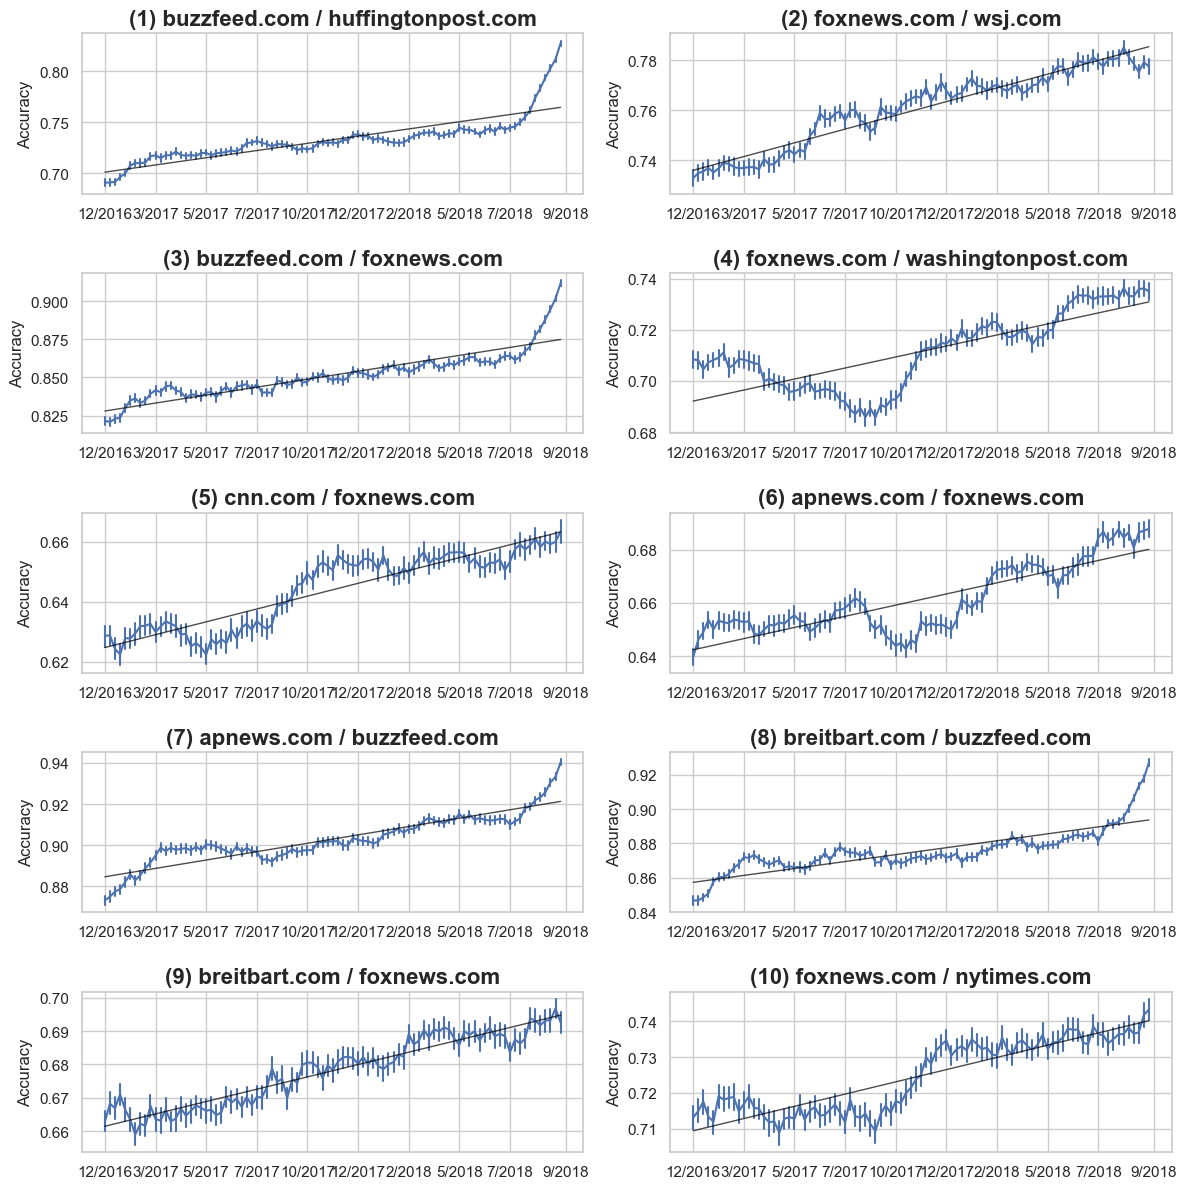

In [33]:
plot_pairs(lr_df.sort_values('slope', ascending=False).head(10), 'figures/ts-ab-rising.png')

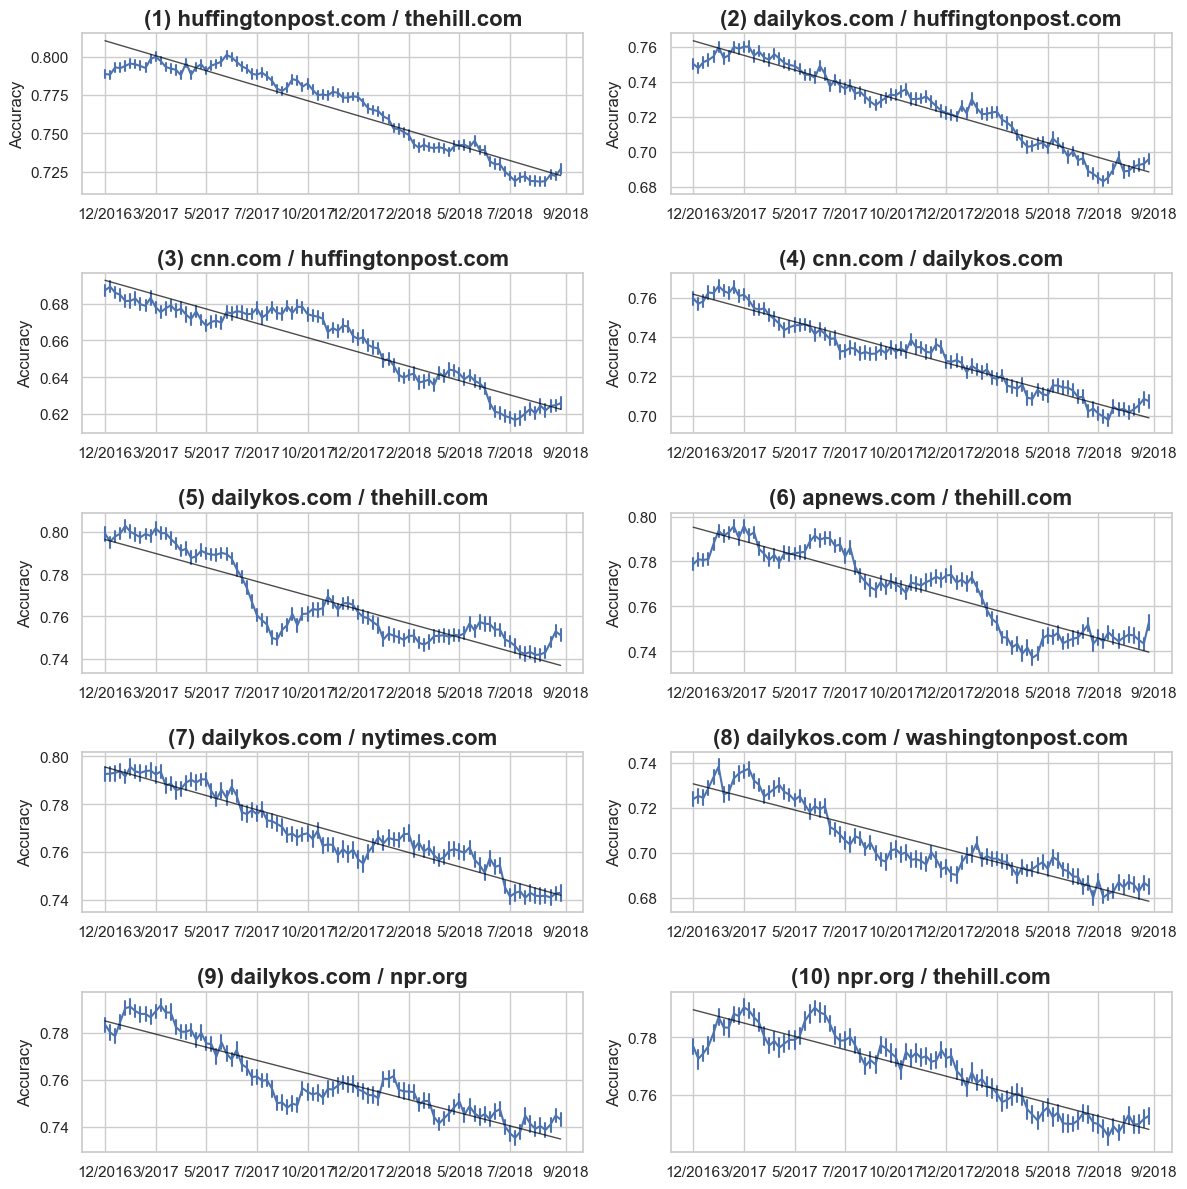

In [34]:
plot_pairs(lr_df.sort_values('slope', ascending=True).head(10), 'figures/ts-ab-falling.png')

In [11]:
lr_df['label'] = lr_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

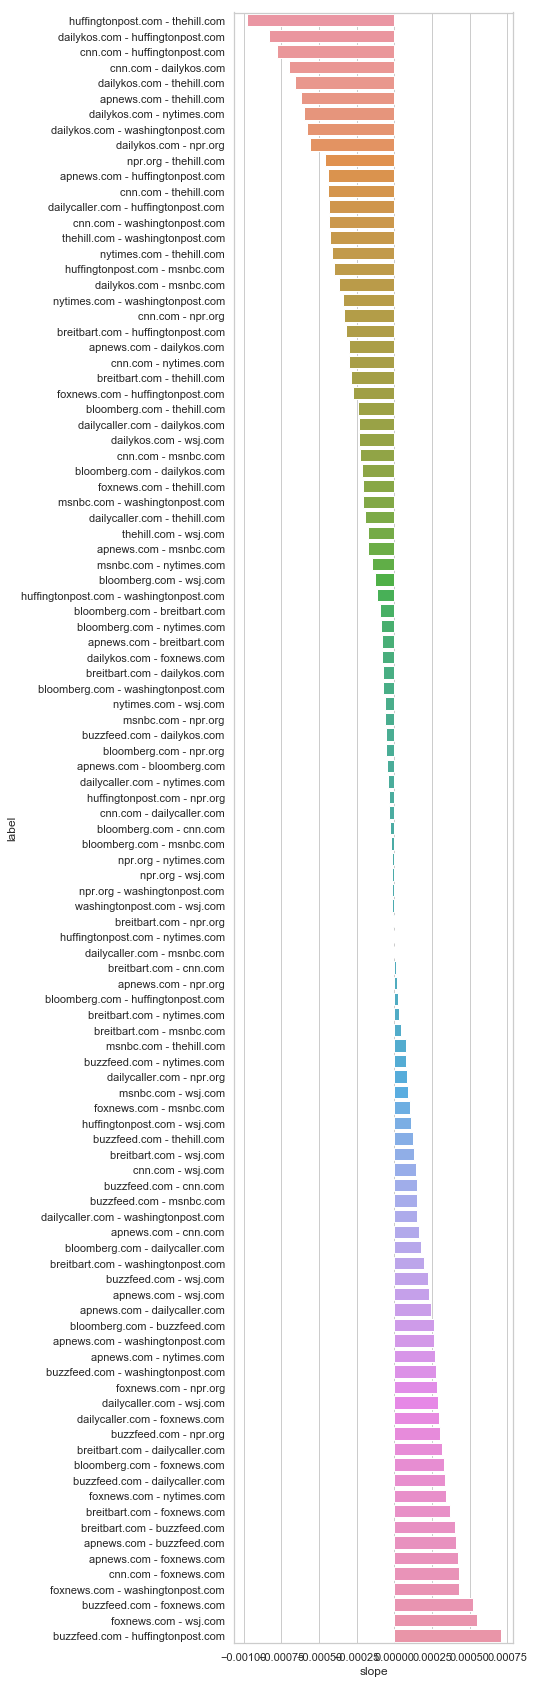

In [111]:
plt.figure(figsize=(5,30))
sns.barplot(x='slope', y='label', data=lr_df.sort_values('slope'))

In [12]:
lr_df['color'] = lr_df.slope.apply(lambda s: 'red' if s > 0 else 'blue')
lr_df['width'] = preprocessing.minmax_scale(abs(lr_df.slope), (0,3)) ** 2

In [13]:
g = nx.Graph()
for r in lr_df.sort_values('slope').itertuples():
    g.add_edge(r.d1, r.d2, width=r.width, color=r.color)

In [14]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


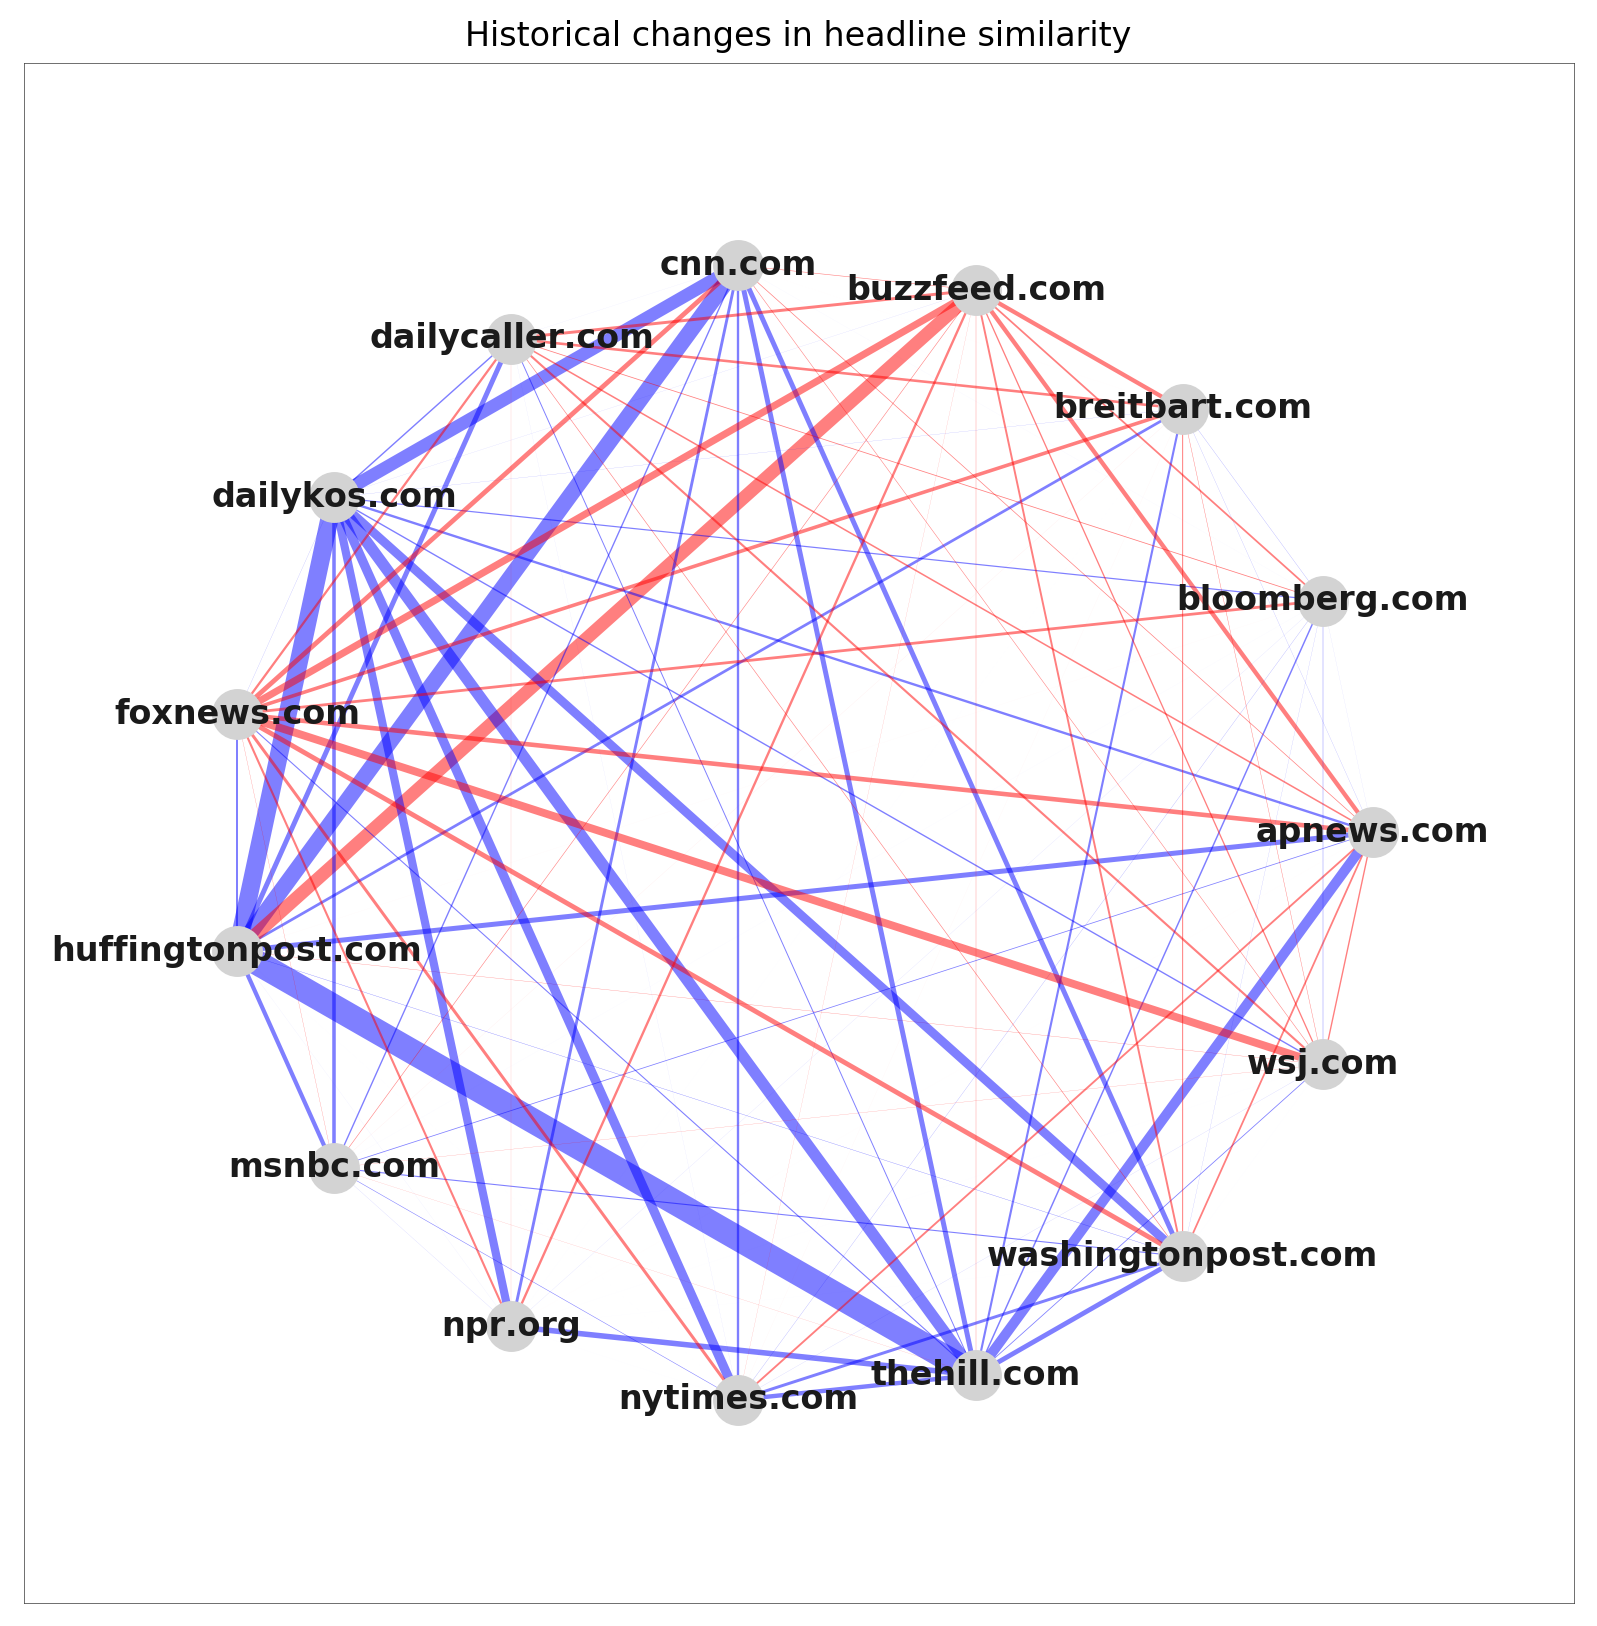

In [17]:
mpl.style.use('default')
plt.figure(figsize=(10,10), dpi=200)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Historical changes in headline similarity')

pos = nx.layout.circular_layout(sorted(g.node))
nx.draw_networkx_nodes(g, pos, node_color='lightgray')
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos, font_weight='bold')

plt.savefig('figures/ts-ab-radial.png', bbox_inches='tight')

In [116]:
lr_df.to_json('data/ts-ab-lr.json', orient='records', lines=True)

In [148]:
pred_df, embeds = read_preds('../../data/ava-ts-cnn/')

100%|██████████| 361/361 [00:19<00:00, 18.66it/s]


In [175]:
len(pred_df[(pred_df.domain=='nytimes.com')&(pred_df.decile==0)])

2146

In [149]:
pred_df['tokens_key'] = pred_df.clf_tokens.apply(lambda ts: tuple(ts))

In [150]:
pred_df = pred_df.drop_duplicates('tokens_key', keep=False)

In [153]:
pred_df_start = pred_df[pred_df.decile==0]
pred_df_end = pred_df[pred_df.decile==9]

In [154]:
idx_start = AnnoyIndex(embeds.shape[1])
for i in tqdm(pred_df_start.index):
    idx_start.add_item(i, embeds[i])
    
idx_end = AnnoyIndex(embeds.shape[1])
for i in tqdm(pred_df_end.index):
    idx_end.add_item(i, embeds[i])

100%|██████████| 26024/26024 [00:02<00:00, 11516.08it/s]


In [155]:
idx_start.build(20)
idx_end.build(20)

True

In [156]:
def mean_cosine_d(domain):
    
    df1 = pred_df_end[pred_df_end.domain==domain]
    df2 = pred_df_start[pred_df_start.domain==domain]
    
    v1 = embeds[df1.index].mean(0)
    v2 = embeds[df2.index].mean(0)
    
    return distance.cosine(v1, v2)

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


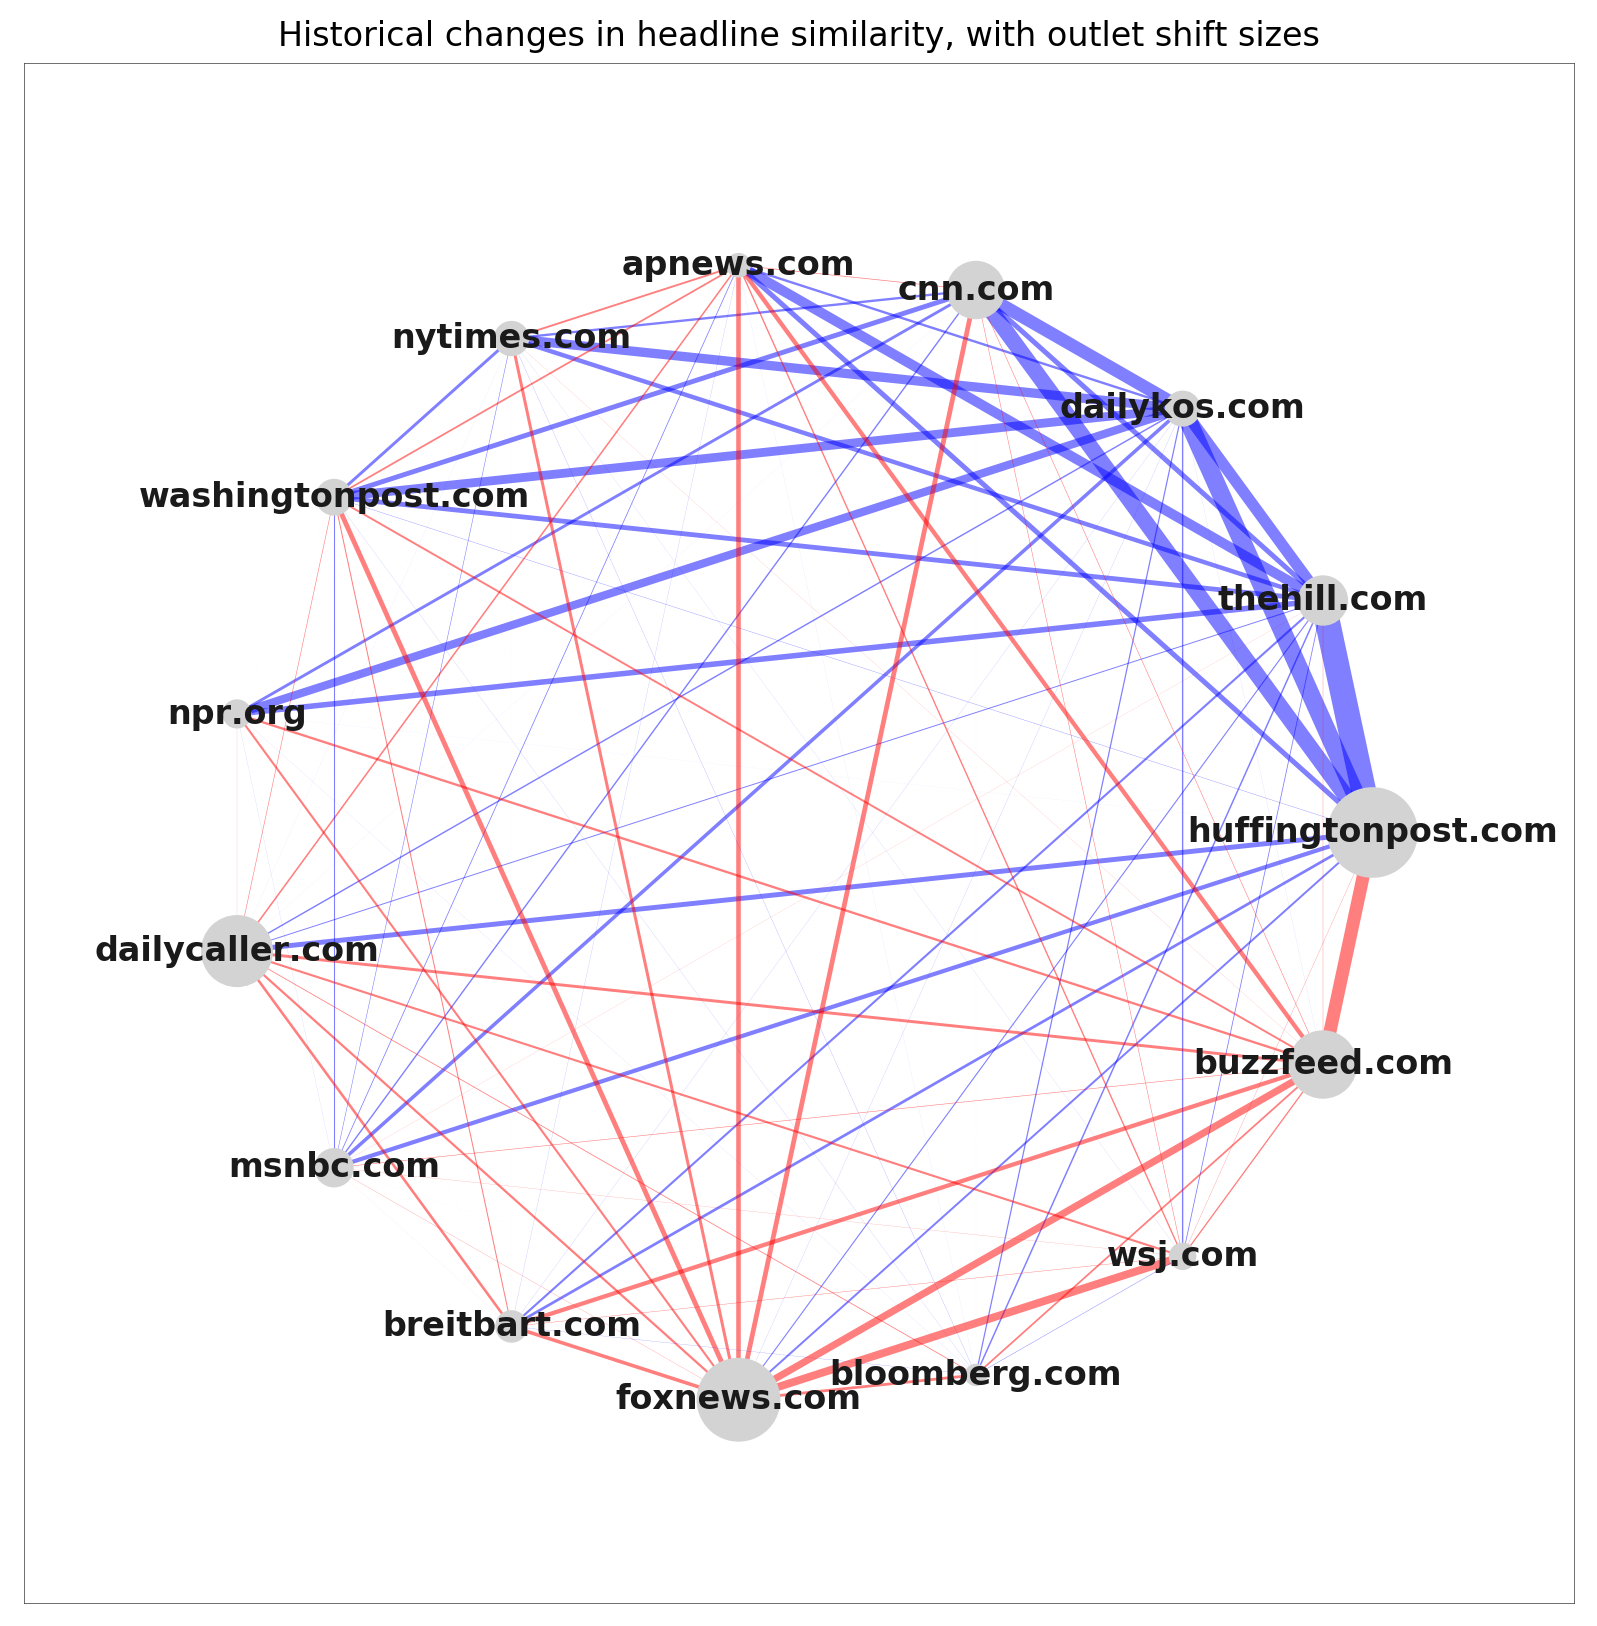

In [179]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]
node_size = preprocessing.minmax_scale([mean_cosine_d(n) for n in g.nodes], (50,1000))

mpl.style.use('default')
plt.figure(figsize=(10,10), dpi=200)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Historical changes in headline similarity, with outlet shift sizes')

pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='lightgray', node_size=node_size)
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos, font_weight='bold')

plt.savefig('figures/ts-ab-radial-magnitude.png', bbox_inches='tight')

In [158]:
def delta_hls(df1, df2, idx, domain=None, n=20, probe=10000):
    
    v1 = embeds[df1.index].mean(0)
    v2 = embeds[df2.index].mean(0)

    matches = 0
    for i in idx.get_nns_by_vector(v2-v1, probe):
        
        r = pred_df.loc[i]
        
        if not domain or r.domain == domain:
            print(' '.join(r.clf_tokens))
            matches += 1
            if matches == n:
                break
                
    print(distance.cosine(v1, v2))

In [159]:
def delta_hls_domain_start(domain):
    
    delta_hls(
        pred_df_end[pred_df_end.domain==domain],
        pred_df_start[pred_df_start.domain==domain],
        idx_start,
        domain,
    )

In [160]:
def delta_hls_domain_end(domain):
    
    delta_hls(
        pred_df_start[pred_df_start.domain==domain],
        pred_df_end[pred_df_end.domain==domain],
        idx_end,
        domain,
    )

# Buzzfeed

In [161]:
delta_hls_domain_start('buzzfeed.com')

congressmen seek to lift propaganda ban
as trump takes office birth control startups see demand spike
trump hotel contractor drops $ # million lawsuit
north carolina officials seek to stop special elections
guardian ditches move to kushner building after newsroom revolt
two key republicans express doubts over devos s nomination
trump warns republicans about botching obamacare repeal before thursday s climactic vote
clinton iowa volunteers train when to push backers to omalley to block bernie
prosecutors win back broad authority to charge supreme court protesters
libyan dissident wins right to sue ex foreign secretary jack straw over rendition
guardian announces layoffs after $ # kushner lease debacle
prosecutors charge protesters with rioting over inauguration day protests
newly designated national monuments highlight nation s civil rights struggle
president trump speaks at cpac conference
trump to address the nation tonight
trump administration keeps major news orgs out of closed pres

In [162]:
delta_hls_domain_end('buzzfeed.com')

pick some colors and we ll tell you which disney movie you should watch
pick your favorite dcoms and we ll tell you which disney heartthrob you belong with
pick # movies and we ll tell you if you re a pessimist or optimist
shop at sportsgirl and we ll tell you which pet you should adopt
pick some fruits and we ll guess your favorite disney princess
pick a movie from each year and we ll tell you which comedy show you belong on
pick some disney movies and we ll reveal your disney soulmate
build your own disney storyline and we ll reveal your prince
choose some food combos and we ll reveal which iconic duo you and your bff are
choose some disney channel characters and we ll reveal if you re more extroverted or introverted
pick nine random things and we ll tell you which sex and the city girl you are
choose your favourite lyrics from the harry styles album and we ll tell you which of his suits you are
build your own spooky restaurant and we ll tell you what costume you should wear for hall

# HuffPo

In [163]:
delta_hls_domain_start('huffingtonpost.com')

how many people are vegetarian
the rise of deaftalent
the problem with tickling
do women really need a yearly pelvic exam
your favorite book characters are as real as you feel they are
the genius trick for oatmeal that ll make your mornings easier
make your goals stick
start where you are
a life in transitions the firsts
shopping with an avatar
the future of food is black
the art of being kind
how to make vegan parmesan cheese and make your dreams come true
a lesson in organicology
how dieting makes you gain weight
tired of mid century modern try these cozy couches instead
the revolting reason you might want to avoid canned greens
why the floor is your friend
the most anticipated books of # thus far
the easiest salmon teriyaki you ve ever made
0.04886126518249512


In [164]:
delta_hls_domain_end('huffingtonpost.com')

susan collins receives # coat hangers ahead of kavanaugh vote
tennessee man accused of burning black man alive was known white supremacist
karl rove likens trump to stalin tells him to tone down anti press rants
omarosa claims trump has mental decline that could not be denied
country star gretchen wilson arrested after altercation on american airlines flight
georgia cop suspended after liking racist kkk facebook posts
c span caller unleashes racist rant about barack obama on air
kathy griffin tells tomi lahren to go herself in scathing tweet
twitter users shred trump for attacking labor leader on labor day
gop rep duncan hunter wife indicted by grand jury in san diego
democrats denounce ivanka trump for hypocrisy after she touts american jobs
omarosa releases secret tape of lara trump discussing high paying campaign job
it s time to decriminalize immigration say top texas dems
maxine waters warns trump cabinet steel yourself for more public confrontations
trump supporter arrested for t

# Fox

In [165]:
delta_hls_domain_start('foxnews.com')

are government leaders turning a blind eye toward debt
biggest movies to look forward to in #
bao bao ready for new life in china
mayim bialik to register as muslim
testing wearable sensors as check engine light for health
why outdated seat belts may be putting lives at risk
alitalia workers vote on cuts to stave off bankruptcy
eurozone economic sentiment at near decade highs
severe bolivian drought hurts crops threatens capital
# minutes to a flatter firmer belly
schools in rural areas shifting toward a # day week
swede who made numbers and facts entertaining dies at #
fewer fret over more focus on politics
seiu s fight for $ # a flop despite spending $ # million
winds from monster black holes can rapidly change their temperature
a crash course in creative destruction
dubai has new safety rules after high rise fires but few details
apple s new spaceship hq set to open
a former model starved to death but not from anorexia
nigerian governor aid agencies misusing refugee funds
0.04138302

In [166]:
delta_hls_domain_end('foxnews.com')

stars rally around liberal james gunn after offensive tweets unlike reaction to trump supporting roseanne barr
washington state store clerk left to die by teen robbers after suffering heart attack cops say
until the kneeling happened fl police union official backs call to return nfl tickets over protests
ocasio cortez claims solidarity with cab drivers while campaign buys rides from uber other alternatives fec data show
gunman shot by florida armed bystander still hospitalized nra says shooting example of good guy with a gun
papa john schnatter allegedly refused to work with kanye west because of n word in his lyrics
anne hathaway calls out white privilege in wake of black woman stabbed to death at bart station
abc news star joy behar finally apologizes for anti christian remarks vice president pence is right
trump predicts electoral doom for democrats with abolish ice push they re going to get beaten so badly
matt lauer complains he s an easy mark victim of misinformation in first int

# DailyKos

In [167]:
delta_hls_domain_start('dailykos.com')

the everything terrible the trump administration has done so far omnibus week #
adam schiff is showing the country what we should expect from our leaders
mike pence my private emails are totally different from hillary s private emails
all the ways trump can sabotage a totally not exploding obamacare
two thirds of americans want a special prosecutor to investigate trump s russia ties
they ve learned nothing the media cheers trump s decisiveness on beautiful missile strikes
federal prosecutor calls jeff sessions immigration crackdown horrifying
forget that confirmation nonsense trump s state dept pick will absolutely get a full senate vote
this gay gop group still thinks trump is pro lgbt despite his anti lgbt administration
angry trump adviser blames fake news abruptly leaves university panel after only five questions
msm scorches trump and bannon for their opposition party and fake news idiocy
it s over breitbart trashes trumpcare as disaster for the gop
the dead pool ryan s aca replac

In [168]:
delta_hls_domain_end('dailykos.com')

action alert providence ri now as in right now
day sixteen kremlinannex #pm et
primary night pot beer and dead fish
november coming into focus
supermarket check out line
wells fargo blames computer glitch for hundreds of customers lost homes
retired teacher sentenced to # # months in case brought by energy transfer partners
astonishing news from mexico little or no coverage
uk identifies russians who made nerve agent attack on skripals
plenty of space on the ark for dinosaurs
turn the plane around
glacier park the lake mcdonald ranger station
california court cracks down on widespread wage theft
steve king makes headlines again time to say enough
when the tough get going the guilty get surreal
magnitsky lawyer falls from moscow window
the boys are back in town
shepard smith does it again
mgm resorts files suit against # victims of # las vegas shooting
african americans asians yet to recover income lost in great recession
0.005823194980621338


# The Hill

In [169]:
delta_hls_domain_start('thehill.com')

us british leaders eye trade deal
fox executives fear more to come
russia blocks un resolution on syria
secret service director to retire
north korea ballistic missile test fails
airlines promise friendlier skies
trump to revamp intelligence agencies
trump hotels eyes us expansion
nuclear anxiety grows with north korea standoff
syrian father us strike not enough
fda industry fear wave of medical device hacks
russian security officers charged in yahoo hack
refugee pause may be necessary
fda proposal on biotech drugs sparks criticism
knock knock economic ivory tower meet retail reality
us finds link between russia wikileaks
southwest to stop overbooking flights
north korea fires into sea of japan
immigration ca nt be turned against us
china on high alert over north korea
0.01335674524307251


In [170]:
delta_hls_domain_end('thehill.com')

police chief disgusted after his son arrested for allegedly beating # year old sikh man
the bachelorette s garrett yrigoyen says he did nt mean to hurt anybody by liking offensive posts
video of swedish woman stopping afghan man s deportation by refusing to sit down on plane goes viral
father pushing baby stroller arrested for allegedly shoving man during racist tirade
majority of americans say nfl players have the right to protest by taking a knee during anthem
trump revokes brennan s security clearance twitter cracks down on infowars hit with crypto lawsuit dhs hosts election security exercise
georgia school superintendent put on leave after alleged audio recording of racist rant
ellen degeneres donates $ # k to scholarship fund for gay high school valedictorian kicked out by his parents
court grants ban of fish imports from mexico caught with nets that hurt endangered porpoise
alabama sheriff who pocketed $ #k in money intended to feed inmates selling $ #k beach house
police officer

# Daily Caller

In [171]:
delta_hls_domain_start('dailycaller.com')

# s record warmth brought record crop yields fewer storms
astronomers may soon restore pluto to planet status
millions of us jobs lost to trade with china study shows
will the lewis gambit work
watch the first ever robotic bee pollinate a flower
a positive jobs report could mean interest rate hike
trump s immigration order has investors buying prison bonds
mulvaney set to tell agencies to prep for substantial cuts
daywithoutimmigrants leads to immigrantswithoutjobs
the tower may have fallen
how dictators and dummies get started
boys with vaginas cause confusion in emergency rooms
trump files appeal to reverse judge s halt on immigration order
bush twins to release joint memoir
russia s trump problem
snap chat just went public and
signature solutions s# usa safety
# us troops roll up at russia s doorstep
first private fusion reactor to go online in #
where should the apostrophe go in today s holiday
0.029861629009246826


In [172]:
delta_hls_domain_end('dailycaller.com')

black conservative activist stands with judge jeanine in viral video no group in america more bigoted than leftists
candace owens trashes jim acosta for complaining about anti cnn chants after getting attacked
donna brazile lays out how obama s obsession with his image leeched the democratic party of its vitality
student charged with battery after ripping maga hat off classmate s head slapping teacher
newt gingrich gets real with left wing illegal immigrants you must be an american citizen to vote
dan bongino rips into war on cops so many officers have lost their lives to keep your neighborhoods safe
nike has become a social justice corporation trying to mold colin kaepernick into the next malcolm x says michelle malkin
maryland democrat attempted to shut down immigration conversation by urging the featured speaker to cancel appearance
twitter suspends conservative commentator for opposing trans in military tying extreme muslim beliefs to honor killings
liberal women s group ellison mu